In [1]:
import os
import matplotlib.pyplot as plt
import torch
from box import Box
import cv2
from PIL import Image
import numpy as np
import scipy.interpolate as interpolate
from torchvision import transforms
from matplotlib import animation
from IPython.display import HTML
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "C:\\Dev\\ContourDetectionGCN\\gcn_ultrasound_segmentation")

In [3]:
from engine import load_trained_model, run_single_epoch

In [4]:
config = Box(
    batch_size = 8,
    num_workers = 12,
    num_examples_to_plot = 1000,
    is_gpu = True,
    weights= "/home/deeplearning/Data/ContourDetection/network_weights/weights_5ch_VAEGCN_best_kptsErr.pth",
    data_path = "/home/deeplearning/Data/ContourDetection/labeled_data/val/movies/",
    input_size=224,
)

In [5]:
model, train_params, trained_ds = load_trained_model(weights_filename=config['weights'])
model = model.cuda()
model.eval();

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_5ch_VAEGCN_best_kptsErr.pth..
epoch is 1050
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='5ch', epochs=100000, eval_each_epoch=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0


current_train_loss = 0.001483
current_val_loss = 0.001714
best_val_metric = 4.810833
Host name: gamma04
Saved to: storage/logs/5ch/VAEGCN/resnext101/5/weights_5ch_VAEGCN_best_kptsErr.pth


## Get movie files

In [6]:
movie_files = [os.path.join(config.data_path, f) for f in os.listdir(config.data_path)]
movie_df = pd.read_excel("/home/deeplearning/Data/ContourDetection/labeled_data/dataset_movies.xlsx", index_col=0)
val_df = movie_df[movie_df.Dataset=="val"]
val_df.head()

Dataset   file_id   view hospital state_string        location  \
428     val  2110020A    4CH  Leipzig           ES  daria.kulikova   
429     val  2110028G    4CH  Leipzig           ES  daria.kulikova   
430     val  211001OS    4CH  Leipzig           ED  daria.kulikova   
431     val  21100088    2CH  Leipzig           ES  daria.kulikova   
432     val  211003GS  APLAX  Leipzig           ES  daria.kulikova   

                                        SOPInstanceUID  \
428  1.2.840.113619.2.118.3430041821.1538429130.2.2...   
429  1.2.840.113619.2.118.3430041821.1538407107.1.3...   
430  1.2.840.113619.2.118.3430041821.1538429039.2.2...   
431  1.2.840.113619.2.118.3430041821.1538427625.2.2...   
432  1.2.840.113619.2.118.3430041821.1538408388.1.5...   

                                            seriesUID  \
428  1.2.840.113619.2.118.3430041821.1538429130.2.254   
429  1.2.840.113619.2.118.3430041821.1538407107.1.326   
430  1.2.840.113619.2.118.3430041821.1538429039.2.235   
431   1.2.840.113619.2.118.3430041821.1538427625.2.25   
432  1.2.840.113619.2.118.3430041821.1538408388.1.580   

                                                  path dicom_type  ...  \
428  C:\Data\LeftVentricleSegmentation\Output\valid...        raw  ...   
429  C:\Data\LeftVentricleSegmentation\Output\valid...        raw  ...   
430  C:\Data\LeftVentricleSegmentation\Output\valid...        raw  ...   
431  C:\Data\LeftVentricleSegmentation\Output\valid...        raw  ...   
432  C:\Data\LeftVentricleSegmentation\Output\valid...        raw  ...   

      LV_x_mean  dset_index         labeler  number_of_frames  \
428  138.269615           0  daria.kulikova             145.0   
429  139.709376           1  daria.kulikova             127.0   
430  142.906191           2  daria.kulikova             158.0   
431  141.302591           3  daria.kulikova             141.0   
432  109.819356           4  daria.kulikova             133.0   

     effective_duration  height_cm   width_cm  movie_index mf_frame_index  \
428             2.96931       16.0  20.505682        214.0          115.0   
429             2.07922       14.0  16.983055        215.0           63.0   
430             2.58831       16.0  19.409205        216.0           57.0   
431             2.30714       14.0  16.983055        217.0           68.0   
432             2.36541       16.0  18.285891        218.0           66.0   

     raw_frame_index  
428            114.0  
429             62.0  
430             56.0  
431             67.0  
432             65.0  

[5 rows x 32 columns]

In [7]:
val_df.columns

Index(['Dataset', 'file_id', 'view', 'hospital', 'state_string', 'location',
       'SOPInstanceUID', 'seriesUID', 'path', 'dicom_type', 'Model',
       'physical_delta_x', 'physical_delta_y', 'basal_left_y', 'basal_left_x',
       'basal_right_y', 'basal_right_x', 'LV_pixel_size', 'LV_contour',
       'LV_height_cm', 'LV_width_cm', 'LV_y_mean', 'LV_x_mean', 'dset_index',
       'labeler', 'number_of_frames', 'effective_duration', 'height_cm',
       'width_cm', 'movie_index', 'mf_frame_index', 'raw_frame_index'],
      dtype='object')

## Converting to cm
`physical_delta_x` and `physical_delta_y` are the size of each pixel in meters (assuming 256x256 image or movie).

`height_cm` and `width_cm` are the height and width of the whole image (assuming 256x256 image or movie). 

Rescale these variables if the image is loaded as another size besides 256x256. since the model outputs a number between 0 and 1 this can be easily done by multiplying by the image size

In [8]:
def convert_to_cm(row, kpts, image_dim=256):
    # model outputs currently need to be multiplied by image_dim so add that here
    cm_conversion = image_dim*np.array([row.physical_delta_x*1e2, row.physical_delta_y*1e2])
    assert kpts.shape[1] == 2, f"kpts should be in shape Nx2, found {kpts.shape}"
    return kpts * cm_conversion

### Display first movie as example

(147, 256, 256)


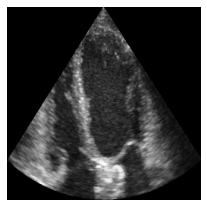

In [7]:
test_movie = np.load(next(iter(movie_files)))
print(test_movie.shape)

dpi = 72.0
xpixels, ypixels = test_movie[0].shape
fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
ax = plt.gca()
ax.axis('off')
mv = plt.imshow(test_movie[0], cmap='gray')

def animate(i):
    mv.set_array(test_movie[i])
    return (mv)

anim = animation.FuncAnimation(fig, animate, frames=test_movie.shape[0], blit=False)
HTML(anim.to_html5_video())

### Simple functions for data loading and plotting

In [13]:
def img_to_torch(img, frame_size=224, transform=transforms.ToTensor()):
    img = cv2.resize(img, dsize=(config.input_size, config.input_size), interpolation=cv2.INTER_AREA)
    img = Image.fromarray(img).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.cuda()
    return img

def plot_kpts_on_frame(img, kpts, frame_size=224, ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.imshow(img)
    
    kpts *= frame_size
    
    interpolation_step_size = 0.001  # 0.01
    unew = np.arange(0, 1.00, interpolation_step_size)
    pred_tck, _ = interpolate.splprep([kpts[:, 0], kpts[:, 1]], s=0)
    pred_interpolate = interpolate.splev(unew, pred_tck)
    ax.scatter(pred_interpolate[0], pred_interpolate[1], marker='.', c='yellow', s=2)
    ax.scatter(kpts[:, 0], kpts[:, 1], marker='.', c='red', s=200)
    clean_ax(ax)
    
def clean_ax(ax):
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    
def model_inference(img, config):
    kpts, _, _, _, _ = model(img_to_torch(img, config.input_size))
    kpts = kpts.cpu().detach().numpy()[0]
    return kpts

def find_apex_index(contour):
    assert contour.shape[0] > 3, "contour should be shape Nx2 where N>3"
    possible_points = contour[1:-1]  # exclude basal points from consideration
    # Find the distance from each point to the two basal points
    distances = np.linalg.norm(possible_points-contour[0], axis=1) + np.linalg.norm(possible_points-contour[-1], axis=1)
    return np.argmax(distances)
    
def find_kpt_consistencies(test_movie, config, row, convert=True):
    kpts_pvs_frame = model_inference(test_movie[0], config)
    if convert:
        assert row is not None, "must pass dataframe row to convert to cm"
        kpts_pvs_frame = convert_to_cm(row, kpts_pvs_frame, config.input_size)
    # Evaluate consistency at 3 points, basal_left, basal_right, and apex.
    # We find the apex index based on the first frame and then keep it constant throughout the analysis
    # This has the downside that if the kpt prediction on the first frame is off and we pick the wrong apex 
    # than it will also cause an error in the apex consistency measurement. Further analysis is needed to see if this is
    # indeed a large issue. Could check the apex index at random frames and see how much it varies to test. 
    indices = dict(basal_left=0, basal_right=-1, apex=find_apex_index(kpts_pvs_frame))
    consistencies=dict(basal_left=0, basal_right=0, apex=0)
    for img in test_movie[1:]:
        kpts_this_frame = model_inference(img, config)
        if convert:
            kpts_this_frame = convert_to_cm(row, kpts_this_frame, config.input_size)
        for kpt_name in consistencies:
            kpt_index = indices[kpt_name]
            consistencies[kpt_name] += np.linalg.norm(kpts_this_frame[kpt_index]-kpts_pvs_frame[kpt_index])
        kpts_pvs_frame = kpts_this_frame
    return consistencies
 
def print_dict(d, suffix="cm"):
    for k, val in d.items():
        print(f"{k}: {val:.2f}{suffix}")
    
def plot_inference_movie(test_movie, config):
    dpi = 72.0
    xpixels, ypixels = test_movie[0].shape
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    ax = plt.gca()
    ax.axis('off')
    interpolation_step_size = 0.001  # 0.01
    unew = np.arange(0, 1.00, interpolation_step_size)
    
    mv = plt.imshow(test_movie[0], cmap='gray')
    
    kpts =model_inference(test_movie[0], config)
    kpts *= config.input_size
#     pred_tck, _ = interpolate.splprep([kpts[:, 0], kpts[:, 1]], s=0)
#     pred_interpolate = interpolate.splev(unew, pred_tck)
#     lns, = ax.scatter(pred_interpolate[0], pred_interpolate[1], marker='.', c='yellow', s=2)
    pts, = ax.plot(kpts[:, 0], kpts[:, 1], marker='o', c='red')

    def animate(i):
        mv.set_array(test_movie[i])
        
        kpts =model_inference(test_movie[i], config)
        kpts *= config.input_size
#         pred_tck, _ = interpolate.splprep([kpts[:, 0], kpts[:, 1]], s=0)
#         pred_interpolate = interpolate.splev(unew, pred_tck)
#         lns.set_data(pred_interpolate[0], pred_interpolate[1])
        pts.set_data(kpts[:, 0], kpts[:, 1])
        return (mv, pts)

    anim = animation.FuncAnimation(fig, animate, frames=test_movie.shape[0], blit=False)
    return anim
    

## Test a movie or two

(159, 256, 256)
basal_left: 26.63cm
basal_right: 39.69cm
apex: 37.72cm


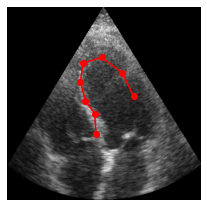

In [14]:
index = 24
test_movie = np.load(movie_files[index])
print(test_movie.shape)
row = val_df[val_df.dset_index==index].iloc[0]
consistencies = find_kpt_consistencies(test_movie, config, row)
print_dict(consistencies)
# print(f"consistency averaged: {consistency} over {test_movie.shape[0]} frames")
anim = plot_inference_movie(test_movie, config)
HTML(anim.to_html5_video())

The problem with the above is that there are multiple cycles in the movie and so the consistency numbers will be summed over all of those cycles. 

basal_left: 20.60cm
basal_right: 23.47cm
apex: 25.66cm


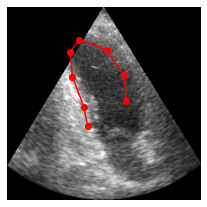

In [15]:
index = 12
test_movie = np.load(movie_files[index])
row = val_df[val_df.dset_index==index].iloc[0]
consistencies = find_kpt_consistencies(test_movie, config, row)
print_dict(consistencies)
# print(f"consistency averaged: {consistency} over {test_movie.shape[0]} frames")
anim = plot_inference_movie(test_movie, config)
HTML(anim.to_html5_video())

## Plot histogram of consistencies

0
50


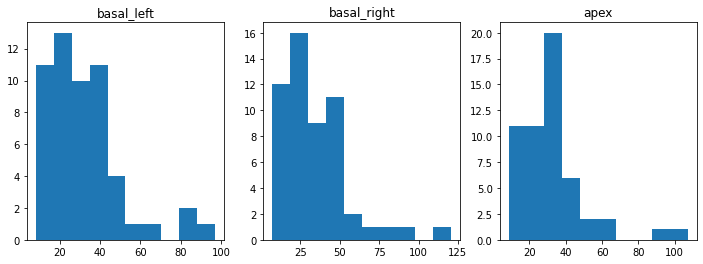

In [12]:
total_consistencies = dict(basal_left=[], basal_right=[], apex=[])
for i in range(len(movie_files)):
    if i%50 == 0:
        print(i)
    test_movie = np.load(movie_files[i])
    row = val_df[val_df.dset_index==i].iloc[0]
    consistencies = find_kpt_consistencies(test_movie, config, row)
    for k in consistencies:
        total_consistencies[k]+=[consistencies[k]]
f, axs = plt.subplots(1, 3, figsize=(12, 4))
for k, ax in zip(total_consistencies, axs.ravel()):
    ax.hist(total_consistencies[k])
    ax.set_title(k)

## Outdated below here

## Plot min movie

consistency averaged: (0.018890577444397177, 141) over 142 frames


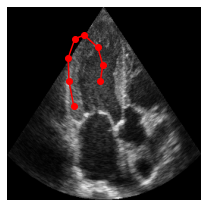

In [75]:
test_movie = np.load(movie_files[np.argmin(consistencies)])
consistency = find_consistency(test_movie, config)
print(f"consistency averaged: {consistency} over {test_movie.shape[0]} frames")
anim = plot_inference_movie(test_movie, config)
HTML(anim.to_html5_video())

## Plot max movie

consistency averaged: (0.08453213813266268, 27) over 28 frames


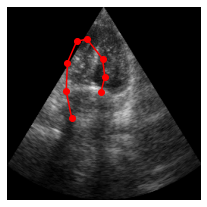

In [76]:
test_movie = np.load(movie_files[np.argmax(consistencies)])
consistency = find_consistency(test_movie, config)
print(f"consistency averaged: {consistency} over {test_movie.shape[0]} frames")
anim = plot_inference_movie(test_movie, config)
HTML(anim.to_html5_video())